# Diagram bifurkacyjny dla równania logistycznego $x \to a x (1-x)$

Równanie logistyczne jest niezwykle prostym równaniem iteracyjnym wykazującym zaskakująco złożone zachowanie. Jego własności są od lat siedemdziesiątych przedmiotem poważnych prac matematycznych. Pomimo tego wciąż wiele własności jest niezbadanych i zachowanie się rozwiązań tego równania jest dostępne tylko do analizy numerycznej.

Poniższy przykład wykorzystuje pyCUDA do szybkiego obliczenia tak zwanego diagramu bifurkacyjnego równania logistycznego. Uzyskanie takiego diagramu wymaga jednoczesnej symulacji wielu równań z różnymi warunkami początkowymi i różnymi parametrami. Jest to idealne zadanie dla komputera równoległego.

Sposób implementacji
--------------------

Pierwszą implementacja naszego algorytmu będzie zastosowanie szablonu jądra zwanego 
    ElementwiseKernel

Jest to prosty sposób na wykonanie tej samej operacji na dużym wektorze danych. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pycuda.gpuarray as gpuarray

from pycuda.curandom import rand as curand
from pycuda.compiler import SourceModule
import pycuda.driver as cuda

try:
    ctx.pop()
    ctx.detach()
except:
    print "No CTX!"

cuda.init()
device = cuda.Device(0)
ctx = device.make_context()
print device.name(), device.compute_capability(),device.total_memory()/1024.**3,"GB"
print "a tak wogóle to mamy tu:",cuda.Device.count(), " urządzenia"


No CTX!
Tesla K40m (3, 5) 11.9998168945 GB
a tak wogóle to mamy tu: 2  urządzenia


## Jądro Elementwise

Zdefiniujemy sobie jądro, które dla wektora stanów początkowych, element po  elementcie wykona iteracje rówania logistycznego. Ponieważ będziemy chcieli wykonać powyższe iteracje dla różnych parametrów $a$, zdefiniujemy nasze jądro tak by brało zarówno wektor wartości paramteru $a$ jak i wektor wartości początkowych. Ponieważ będziemy mieli tą samą wartość parametru $a$ dla wielu wartości początkowych to wykorzystamy użyteczną w tym przypadku funkcję numpy:

    a =  np.repeat(a,Nx)

In [3]:
Nx = 1000
Na = 1000

a = np.linspace(3.255,4,Na).astype(np.float32)
a =  np.repeat(a,Nx)

a_gpu = gpuarray.to_gpu(a)
x_gpu = curand((Na*Nx,))

from pycuda.elementwise import ElementwiseKernel
iterate = ElementwiseKernel(
        "float *a, float *x",
        "x[i] = a[i]*x[i]*(1.0f-x[i])",
        "iterate")


In [4]:
%%time
Niter = 10000
for i in range(Niter):
    iterate(a_gpu,x_gpu)
ctx.synchronize()
print Niter*Na*Nx/1e9

10.0
CPU times: user 520 ms, sys: 160 ms, total: 680 ms
Wall time: 3.32 s


In [5]:
%%time
a,x = a_gpu.get(),x_gpu.get()


CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 4.94 ms


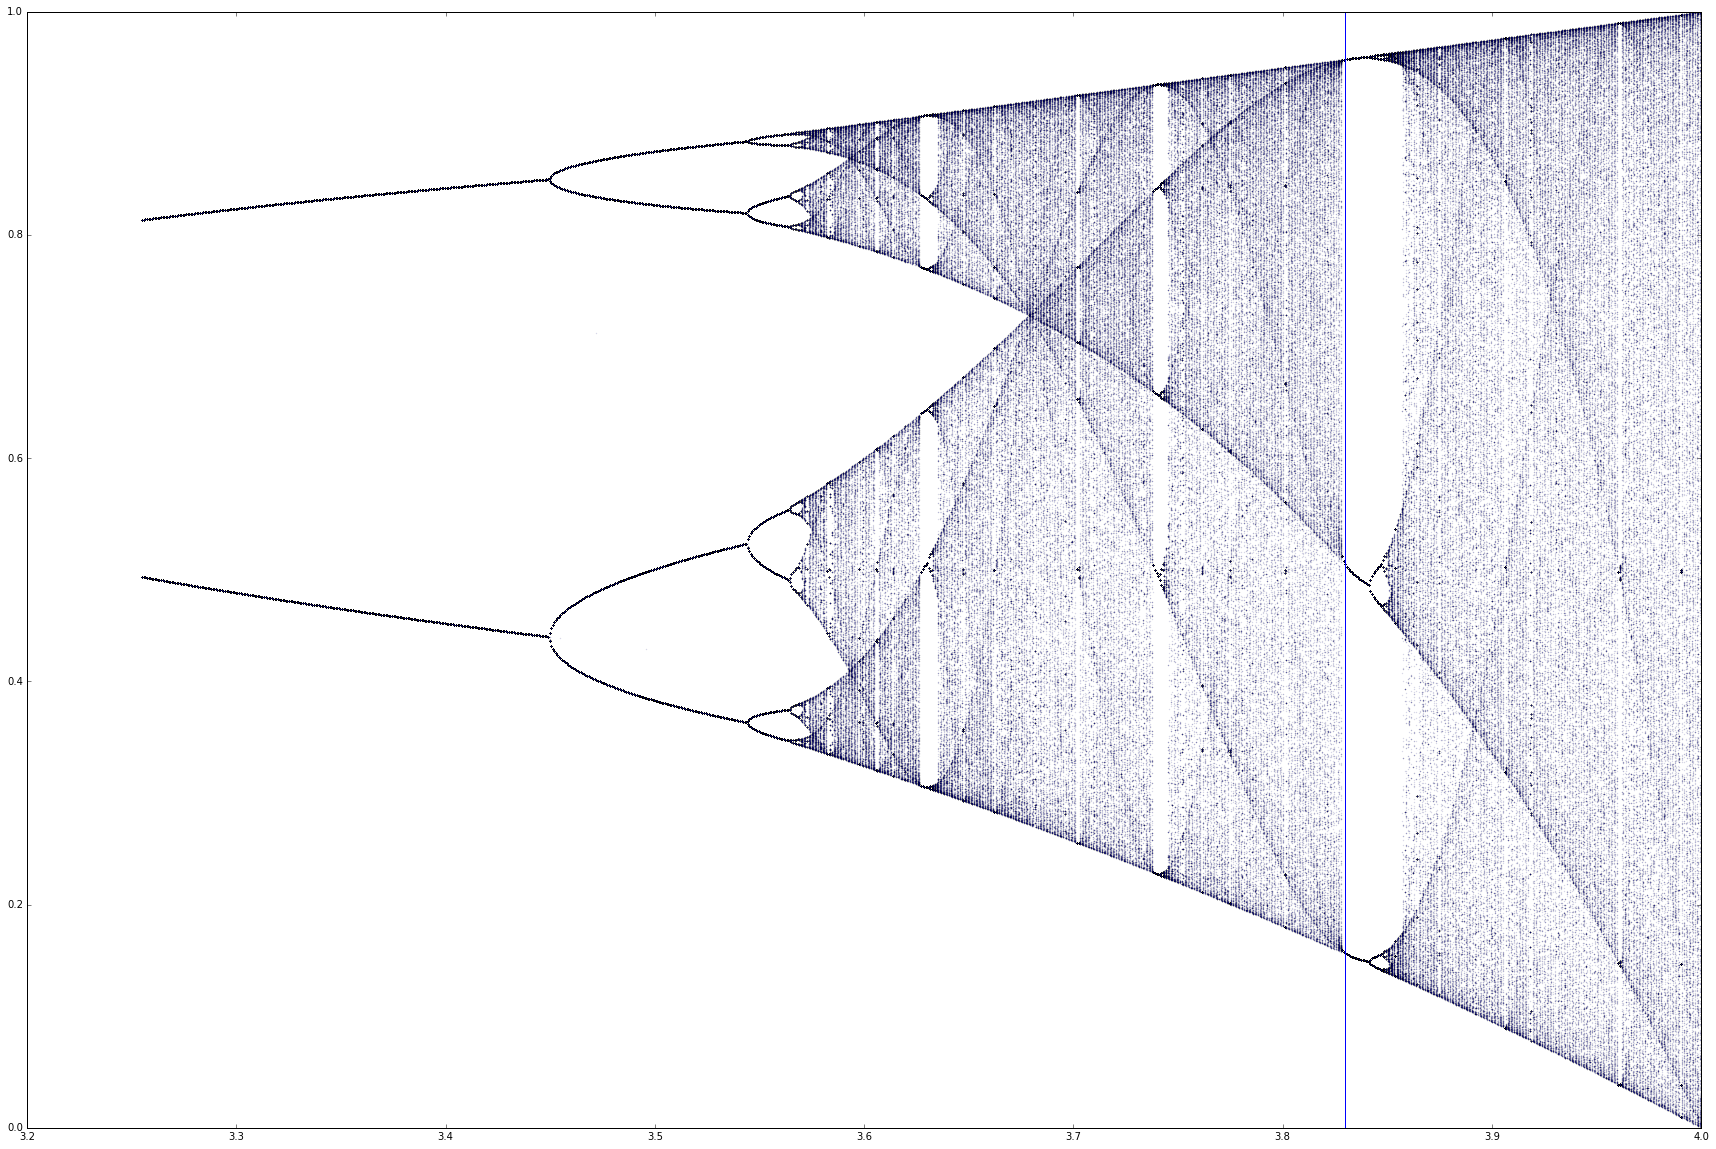

In [6]:
plt.figure(num=1, figsize=(30, 20))
every = 1
plt.plot(a[::every],x[::every],'ob',markersize=1,alpha=0.1)
plt.plot([3.83,3.83],[0,1])

## Algorytm z pętlą wewnątrz jądra CUDA

Napiszmy teraz algorytm, który będzie iterował równanie `Niter` razy wewnątrz jednego wywołania jądra CUDA.

In [7]:
import pycuda.gpuarray as gpuarray

import numpy
from pycuda.curandom import rand as curand
from pycuda.compiler import SourceModule
import pycuda.driver as cuda

try:
    ctx.pop()
    ctx.detach()
except:
    print "No CTX!"

cuda.init()
device = cuda.Device(0)
ctx = device.make_context()


mod = SourceModule("""
    __global__ void logistic_iterations(float *a,float *x,int Niter)
    {
      
      int idx = threadIdx.x + blockDim.x*blockIdx.x;
      float a_ = a[idx];
      float x_ = x[idx];
      int i;
      for (i=0;i<Niter;i++){
        
          x_ = a_*x_*(1-x_);
      }
      
      x[idx] = x_;
    }
    """)
logistic_iterations = mod.get_function("logistic_iterations")

In [8]:
block_size=128
Nx = 1024
Na = 1024
blocks = Nx*Na/block_size

a = np.linspace(3.255,4,Na).astype(np.float32)
a = np.repeat(a,Nx)

a_gpu = gpuarray.to_gpu(a)
x_gpu = curand((Na*Nx,))

In [9]:
%%time
logistic_iterations(a_gpu,x_gpu, np.int32(500*1000),block=(block_size,1,1), grid=(blocks,1,1))
ctx.synchronize()

CPU times: user 2.35 s, sys: 352 ms, total: 2.7 s
Wall time: 2.7 s


CPU times: user 60 ms, sys: 12 ms, total: 72 ms
Wall time: 69 ms


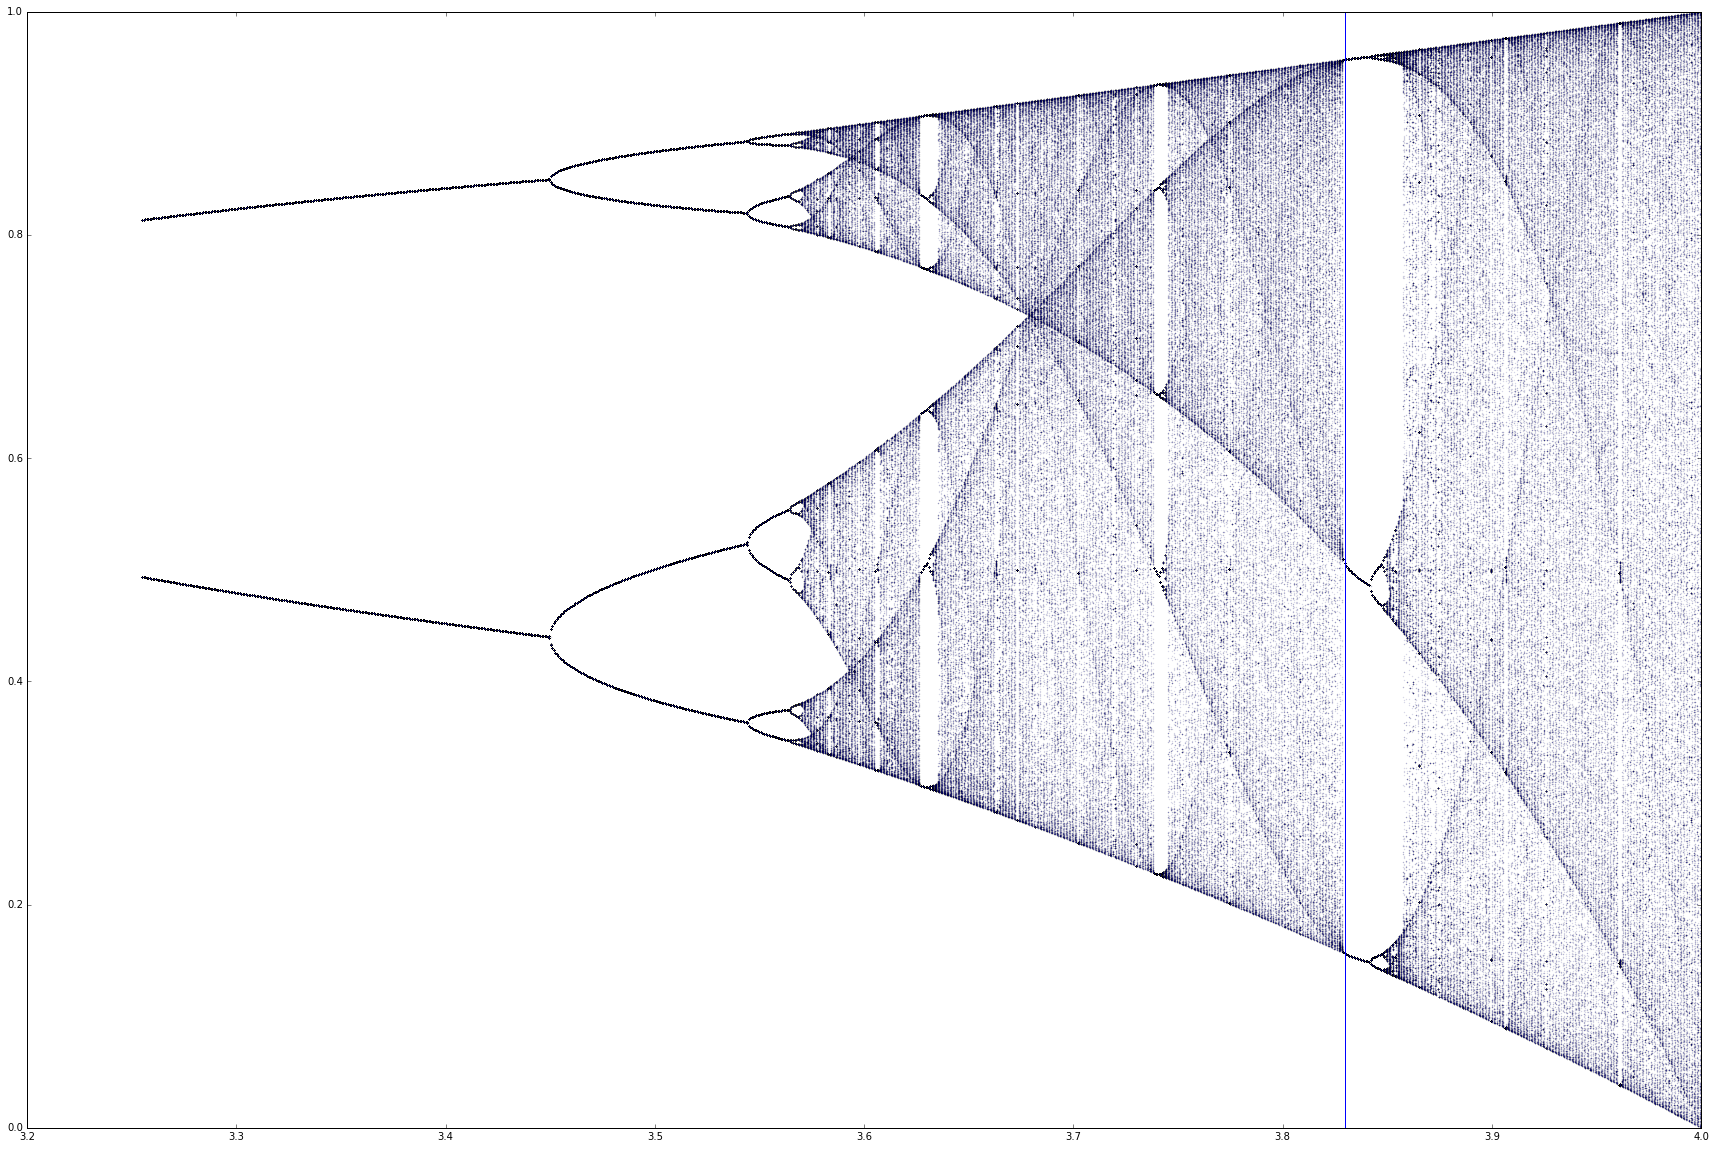

In [10]:
%%time
a,x = a_gpu.get(),x_gpu.get()
plt.figure(num=1, figsize=(30, 20))
every = 1
plt.plot(a[::every],x[::every],'ob',markersize=1,alpha=0.1)
plt.plot([3.83,3.83],[0,1])

## Porównanie z wersją CPU

Dla porównania napiszemy prosty program, który oblicza iteracje równania logistycznego na CPU. Zatosujemy język cython, który umożliwia automatyczne skompilowanie funkcji do wydajnego kodu, którego wydajność jest porównywalna z kodem napisanym w języku C lub podobnym.

W wyniku działania programu widzimy, że nasze jądro wykonuje obliczenia znacznie szybciej.

In [11]:
%load_ext Cython

In [12]:
%%cython
def logistic_cpu(double a = 3.56994):
    cdef double x
    
    cdef int i
    x = 0.1
    for i in range(1000*1024*1024):
        x = a*x*(1.0-x)
        
    return x

In [13]:
%%time
logistic_cpu(1.235)

CPU times: user 3.38 s, sys: 0 ns, total: 3.38 s
Wall time: 3.37 s


0.19028340080971662

## Wizualizacja wyników